<a href="https://colab.research.google.com/github/joshbrx/DataScience_challenge/blob/main/Departamentos_en_la_CDMX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Pregunta 1***
El archivo ``reto_precios.csv`` contiene información sobre precios de departamentos nuevos dentro de la CDMX, junto con diversas características del inmueble.

Para esta pregunta,requerimos que nos puedas explicar los factores que influyen en el precio por metro cuadrado de cada vivienda

***Hint: Existe información externa que te podría ser útil para resolver esta pregunta*.**



---



In [435]:
!pip install -q geopandas

In [436]:
import numpy as np
import pandas as pd
import geopandas as gpd
import re
import requests

import matplotlib.pyplot as plt
import seaborn as sns
import plotly
# import plotly.graph_objects as go
import plotly.express as px


In [437]:
url = "https://raw.githubusercontent.com/joshbrx/DataScience_challenge/main/reto_precios.csv"
df = pd.read_csv(url)
df.head()

,main_name,subtitle,link,location,price,attributes,timestamp,id,address,since,...,apartments_per_floor,disposition,parking_lots,floor_situated,orientation,num_bedrooms,department_type,m2,final_price,price_square_meter
0,Departamento - Roma Norte,Departamento en venta,https://departamento.metroscubicos.com/MLM-139...,"Sinaloa 20 , Roma Sur, Roma Sur, Cuauhtémoc, D...",9000000 pesos,"127 m² construidos,2 recs.",2022-03-29,1,"Sinaloa 20 , Roma Sur",Publicado hace 5 días,...,NaN,Contrafrente,2,NaN,NaN,2.0,NaN,127.0,9000000.0,70866.141732
1,Preventa Exclusiva · Terraloza Roma Norte ·,Departamento en venta,https://departamento.metroscubicos.com/MLM-139...,"Tonala, Roma Norte, Cuauhtémoc, Distrito Federal",4264000 pesos,"54 m² construidos,1 rec.",2022-03-29,2,Tonala,Publicado hace 7 días,...,NaN,NaN,1,NaN,NaN,1.0,NaN,54.0,4264000.0,78962.962963
2,Townhouse Único En La Roma Sur,Departamento en venta,https://departamento.metroscubicos.com/MLM-139...,"Tepeji 43, Roma Sur, Ciudad De México, Cdmx, M...",8093500 pesos,"163 m² construidos,3 recs.",2022-03-29,3,"Tepeji 43, Roma Sur, Ciudad De México, Cdmx, M...",Publicado hace 4 días,...,NaN,NaN,2,NaN,NaN,3.0,NaN,163.0,8093500.0,49653.374233
3,"Departamento En Roma Sur, Cuauhtémoc Con 2 Rec...",Departamento en venta,https://departamento.metroscubicos.com/MLM-132...,"Linares, Roma Sur, Cuauhtémoc, Distrito Federal",4000000 pesos,"93 m² construidos,2 recs.",2022-03-29,4,Linares,Publicado hace 5 meses por {action},...,NaN,NaN,1,NaN,Oeste,2.0,Loft,93.0,4000000.0,43010.752688
4,Últimos Deptos En Preventa En Roma Norte,Departamento en venta,https://departamento.metroscubicos.com/MLM-137...,"Frontera, Roma Norte, Cuauhtémoc, Distrito Fed...",6732700 pesos,"103 m² construidos,2 recs.",2022-03-29,5,Frontera,Publicado hace 52 días,...,NaN,NaN,1,NaN,NaN,2.0,NaN,103.0,6732700.0,65366.019417


## Análisis exploratorio y limpieza en base de datos

Es necesario poder comprender el tipo de datos con el que estamos trabajando para poder realizar posteriormente una limpieza de los mismos.

In [438]:
# Se define una copia de "df" llamada "data_cdmx" para poder limpiarla y no modificar la base de datos inicial, ni perder información.
data_cdmx = df.copy()

In [439]:
df.info()
# df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 981 entries, 0 to 980
Data columns (total 35 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   main_name             981 non-null    object 
 1   subtitle              981 non-null    object 
 2   link                  981 non-null    object 
 3   location              981 non-null    object 
 4   price                 981 non-null    object 
 5   attributes            981 non-null    object 
 6   timestamp             981 non-null    object 
 7   id                    981 non-null    int64  
 8   address               702 non-null    object 
 9   since                 981 non-null    object 
 10  description           981 non-null    object 
 11  vendor                981 non-null    object 
 12  lat                   981 non-null    float64
 13  lon                   981 non-null    float64
 14  price_mod             981 non-null    float64
 15  price_currency        9

### Columnas repetidas y triviales

En el primer caso, repiten los mismos valores por lo que no son relevantes

In [440]:
df[["subtitle", "timestamp", "price_currency", "age_in_years", "age_in_years"]].head(10)
data_cdmx = data_cdmx.drop(["subtitle", "timestamp", "price_currency", "age_in_years", "age_in_years"], axis=1);

En el segundo caso, las siguientes columnas son triviales u otorgan información redundante.

* `attributes` (Consta de 2 variables, la primera corresponde con `m2` y la segunda con `num_bedrooms`)

In [441]:
# Hay 2 variables comprimidas en `attributes` (la primera corresponde con la columna `m2` y la segunda con `num_bedrooms`)
df.iloc[:,[0,5,30,32]].head()

,main_name,attributes,num_bedrooms,m2
0,Departamento - Roma Norte,"127 m² construidos,2 recs.",2.0,127.0
1,Preventa Exclusiva · Terraloza Roma Norte ·,"54 m² construidos,1 rec.",1.0,54.0
2,Townhouse Único En La Roma Sur,"163 m² construidos,3 recs.",3.0,163.0
3,"Departamento En Roma Sur, Cuauhtémoc Con 2 Rec...","93 m² construidos,2 recs.",2.0,93.0
4,Últimos Deptos En Preventa En Roma Norte,"103 m² construidos,2 recs.",2.0,103.0


In [442]:
# Los datos de "attributes" y "m2" solo difieren en una pequeña parte
df[df['attributes'].apply(lambda x: float(re.findall(r'\d+', x)[0])) != df['m2']].iloc[:,[0,5,32]].head()

,main_name,attributes,m2
189,"Preventa De Departamentos, Locales Y Oficinas ...","103 m² construidos,3 recs.",103.10
200,Venta Hermoso Depto Col. Roma Sur Baja California,"95 m² construidos,2 recs.",95.20
205,Departamentos Colonia Roma,"53 m² construidos,1 rec.",53.02
218,Departamento En Venta Colonia Roma Sur,"120 m² construidos,2 recs.",120.24
281,"Departamento En Venta Estilo Ecléctico, Roma N...","96 m² construidos,2 recs.",96.50


In [443]:
# Incluso los datos de "attributes" no llegan a tener el dato del número de habitaciones por lo que ésta columna no es relevante.
def tmp_func1(x):
    if len(re.findall(r'\d+', x))==2:
        s = re.findall(r'\d+', x)[1]
    else: s = "prueba"
    return s
df[df['attributes'].apply(tmp_func1) == "prueba"].iloc[:,[0,5,30]].head()

,main_name,attributes,num_bedrooms
411,Venta Departamento Nuevo Colonia Roma,141 m² construidos,2.0
541,Departamento En Venta Roma Sur,"7,210 m² construidos,2 recs.",2.0
584,Preventa En La Colonia Roma,80 m² construidos,2.0
601,Preventa De Departamentos En Roma Sur,64 m² construidos,2.0
619,"Preventa En La Colonia Roma Norte, Chapultepec",34 m² construidos,2.0


Dado que se repiten los datos de la columna `attributes` e incluso se encuentran mejor descritos en las columnas `m2` y `num_bedrooms`, se elimina esta columna.

In [444]:
data_cdmx = data_cdmx.drop("attributes", axis=1);

* ``orientation`` (irrelevante y mejor mostrada en `lat` y `lon`)

Dado que solo consta de 8 datos registrados en comparación con 981 de la base de datos, se puede descartar.

In [445]:
print(df.iloc[:,29].value_counts())
data_cdmx = data_cdmx.drop("orientation", axis=1);

Poniente    3
Sur         2
Oeste       1
Norte       1
Oriente     1
Name: orientation, dtype: int64


### Extracción de datos

Se suelen minar los datos relevantes (normalmente valores númericos) de una cadena de texto sin limpiar.

#### `price` (se recupera el valor en pesos en forma numérica)

In [446]:
# df[["id", "price"]].head()
data_cdmx["price"] = df['price'].apply(lambda x: int(re.search(r'\d+', x).group()))
data_cdmx[["id", "price"]].head()

,id,price
0,1,9000000
1,2,4264000
2,3,8093500
3,4,4000000
4,5,6732700


#### ``since`` contra `since_period`, ``days_on_site`` y ``since_value``
Como se puede observar, se puede calcular el valor de dias en el sitio a partir de la columna `since` que luego se subdivide en dos columnas más, sin embargo esto se puede mejorar.

In [447]:
df.iloc[:, [7, 9, 16, 17, 18]].head()

,id,since,since_period,since_value,days_on_site
0,1,Publicado hace 5 días,days,5,5.0
1,2,Publicado hace 7 días,days,7,7.0
2,3,Publicado hace 4 días,days,4,4.0
3,4,Publicado hace 5 meses por {action},months,5,150.0
4,5,Publicado hace 52 días,days,52,52.0


In [448]:
# Refinamos el calculo de los días totales para medirlo en función de un mes y año promedio
def tmp_func2(x):
    tmp_var = int(re.findall('\d+', x)[0])
    if re.findall("meses", x) == ['meses']:
        tmp_var *= 30.42
    if re.findall("años", x) == ["años"]:
        tmp_var *= 365.24
    return int(round(tmp_var))

data_cdmx['since'] = df['since'].apply(tmp_func2)
data_cdmx[["id", "since", "days_on_site"]].head()

,id,since,days_on_site
0,1,5,5.0
1,2,7,7.0
2,3,4,4.0
3,4,152,150.0
4,5,52,52.0


Una vez mostrada la comparación se puede continuar a eliminar las columnas adicionales

In [449]:
# Remplazamos estos valores en "days_on_site" y eliminamos las columnas extra
data_cdmx['days_on_site'] = data_cdmx['since']
data_cdmx = data_cdmx.drop(["since", "since_period", "since_value"], axis=1);

### Completar valores nulos

Se rellenan los valores nulos en las columnas incompletas según el contexto o la descripción de la base de datos:

* `amenities` (áreas comunes, vigilancia, servicios extra, etc.)
* `cellars` (Almacenes, bovedas, depósitos, etc.)
* `monthly_fee` (Gastos de mantenimiento, servicios, entre otros)
* `apartments_per_floor` (nùmero de apartamentos por piso)
* `disposition` (Distribución del departamentamento en el edificio)
* `floor_situated` (Piso del edificio en el que se localiza el departamento)
* `department_type` (Loft, penthouse, estudio, duplex)



In [450]:
# falta caso cuando no hay amenidades extra, se rellena con 0
data_cdmx["amenities"] = df["amenities"].fillna(0)

# falta caso cuando no incluye almacén, completamos con 0
data_cdmx["cellars"] = df["cellars"].fillna(0)

# falta casos cuando el edificio es de un solo piso o cuando el departamento está en planta baja, rellenamos valores con 0
data_cdmx["num_floors"] = data_cdmx['num_floors'].fillna(0)

# falta caso cuando no hay gastos de mantenimiento, completamos valores con 0 MXN y limpiamos datos
data_cdmx["monthly_fee"] = df["monthly_fee"].fillna("0 MXN")
data_cdmx['monthly_fee'] = data_cdmx['monthly_fee'].apply(lambda x: int(re.search(r'\d+', x).group()))

# falta caso cuando no hay informacion, que rellenamos valores con 0
data_cdmx["apartments_per_floor"] = df["apartments_per_floor"].fillna(0)

# falta caso cuando no se proporciona información, rellenamos valores con N/A
data_cdmx["disposition"] = df["disposition"].fillna("N/A")

# falta casos cuando el edificio es de un solo piso o cuando el departamento está en planta baja, rellenamos valores con 0
data_cdmx["floor_situated"] = df["floor_situated"].fillna(0)

# falta varios casos por lo se define una categoría general, rellenamos valores con `Normal` dado que no hay más información
data_cdmx["department_type"] = df["department_type"].fillna("Normal")

### Dato mal capturado en ``bathrooms`` y `m2`

Según la base de datos existe un departamento de $91\ m^2$ con 23 baños, algo que no tiene sentido por lo que opta por eliminar el renglón

In [451]:
df[(df["bathrooms"] == 23)].iloc[:, [0, 7,21, 32]]

,main_name,id,bathrooms,m2
687,Departamento En Venta Roma Sur,692,23.0,91.0


Y también hay un departamento con supuestamente $7210\ m^2$ que es equiparable al área de un estadio de futbol. Imposible.

In [452]:
df[(df["m2"] == 7210)][["main_name", "id", "m2"]]

,main_name,id,m2
541,Departamento En Venta Roma Sur,546,7210.0


In [453]:
# Eliminamos estos datos en `data_cdmx`
data_cdmx = data_cdmx.drop(541)
data_cdmx = data_cdmx.drop(687)

In [454]:
data_cdmx[['amenities', 'bathrooms', 'cellars', 'num_floors', 'apartments_per_floor', 'parking_lots', 'floor_situated', 'num_bedrooms']] = data_cdmx[['amenities', 'bathrooms', 'cellars', 'num_floors', 'apartments_per_floor', 'parking_lots', 'floor_situated', 'num_bedrooms']].astype(int)

In [455]:
data_cdmx.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 979 entries, 0 to 980
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   main_name             979 non-null    object 
 1   link                  979 non-null    object 
 2   location              979 non-null    object 
 3   price                 979 non-null    int64  
 4   id                    979 non-null    int64  
 5   address               700 non-null    object 
 6   description           979 non-null    object 
 7   vendor                979 non-null    object 
 8   lat                   979 non-null    float64
 9   lon                   979 non-null    float64
 10  price_mod             979 non-null    float64
 11  days_on_site          979 non-null    int64  
 12  amenities             979 non-null    int64  
 13  bathrooms             979 non-null    int64  
 14  cellars               979 non-null    int64  
 15  num_floors            9



---



---


## Análisis y correlación entre las variables

In [456]:
sns.set_style("darkgrid")

def violin_plot(df, variables, n_rows, n_cols, figsize=(14,14)):
    fig, axs = plt.subplots(n_rows, n_cols, sharex=False, sharey=True, figsize=figsize)
    axs_flat = axs.flatten()

    for i, var in enumerate(variables):
        asset = df.loc[:,var]
        sns.violinplot(x=asset, y=df["price"], ax=axs_flat[i])
        # axs_flat[i].(asset, df["price"], c=cmap((i/10)%1), s=8)
        axs_flat[i].set_xlabel("{}".format(var))
        axs_flat[i].set_title("Price vs "+ var)
        if (i % 4) == 0 : axs_flat[i].set_ylabel("Price")
        plt.setp(axs_flat[i].get_xticklabels(), rotation=45)
    plt.suptitle("Distribución de precios para cada variable\n", fontsize=16)
    fig.tight_layout()
    plt.show()

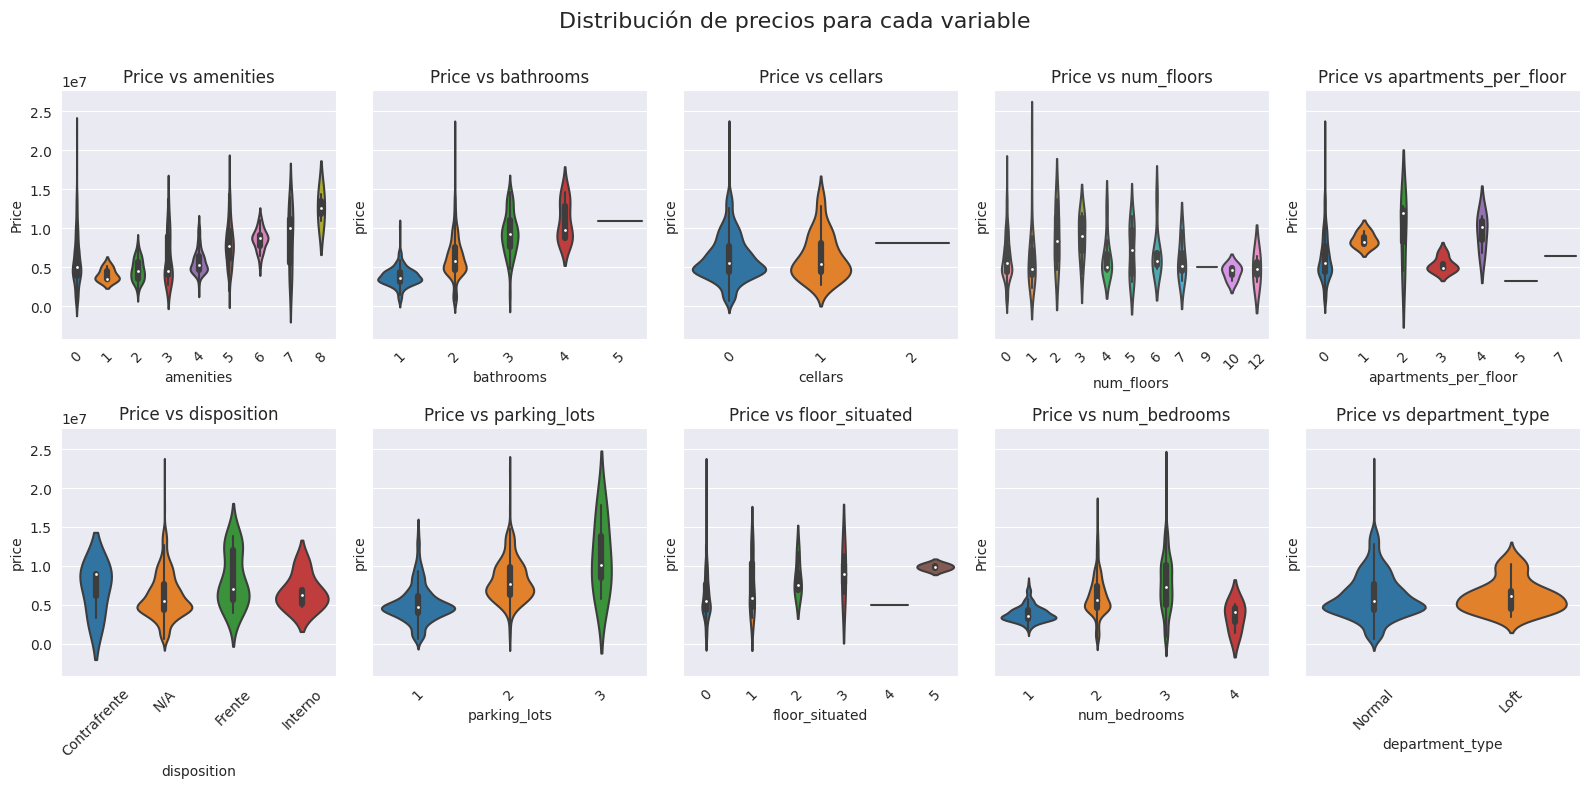

In [457]:
variables = data_cdmx[['amenities', 'bathrooms', 'cellars', 'num_floors',
       'apartments_per_floor', "disposition", 'parking_lots', 'floor_situated',
       'num_bedrooms', "department_type"]]
# variables = data_cdmx.columns[['Number_of_Rooms','House_Inside_Area','Population','Population_Density(km2)','Altitude_min(m)', 'Avg_Temperature','Number_of_Schools','Number_of_Hospital','Region_Area(km2)','Precipitation','Avg_Monthly_Salary','Avg_Age']]

violin_plot(data_cdmx, variables, 2, 5, figsize=(16,8))

La correlación entre `price` y las variables numéricas relevantes de `data_cdmx` se muestran en las gráficas siguientes.

In [458]:
cmap = plt.get_cmap('tab10')

def correlation_plot(df, variables, n_rows, n_cols, figsize=(14,14), log=None, log_log=None):
    # colors = cmap(np.linspace(0,1,len(variables)))
    fig, axs = plt.subplots(n_rows, n_cols, sharex=False, sharey=False, figsize=figsize)
    axs_flat = axs.flatten()

    for i, var in enumerate(variables):
        asset = df.loc[:,var]
        axs_flat[i].scatter(asset, df["price"], c=cmap((i/10)%1), s=8)
        axs_flat[i].set_xlabel("{}".format(var))
        axs_flat[i].set_title("Price vs "+ var)
        if (i % 4) == 0 : axs_flat[i].set_ylabel("Price")
        plt.setp(axs_flat[i].get_xticklabels(), rotation=45)
    if log == None: pass
    else:
        if i in log:
            axs_flat[i].set_xscale('log')
            axs_flat[i].set_yscale('linear')
        else:
            axs_flat[i].set_xscale('linear')
            axs_flat[i].set_yscale('linear')
    if log == None: pass
    else:
        if i in log_log:
            axs_flat[i].set_xscale('log')
            axs_flat[i].set_yscale('log')
        else:
            axs_flat[i].set_xscale('linear')
            axs_flat[i].set_yscale('linear')
    plt.suptitle("Correlación de precio contra variables  \n", fontsize=16)
    fig.tight_layout()
    plt.show()

<ipython-input-458-bde7b0dc6840>:10: UserWarning:

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.



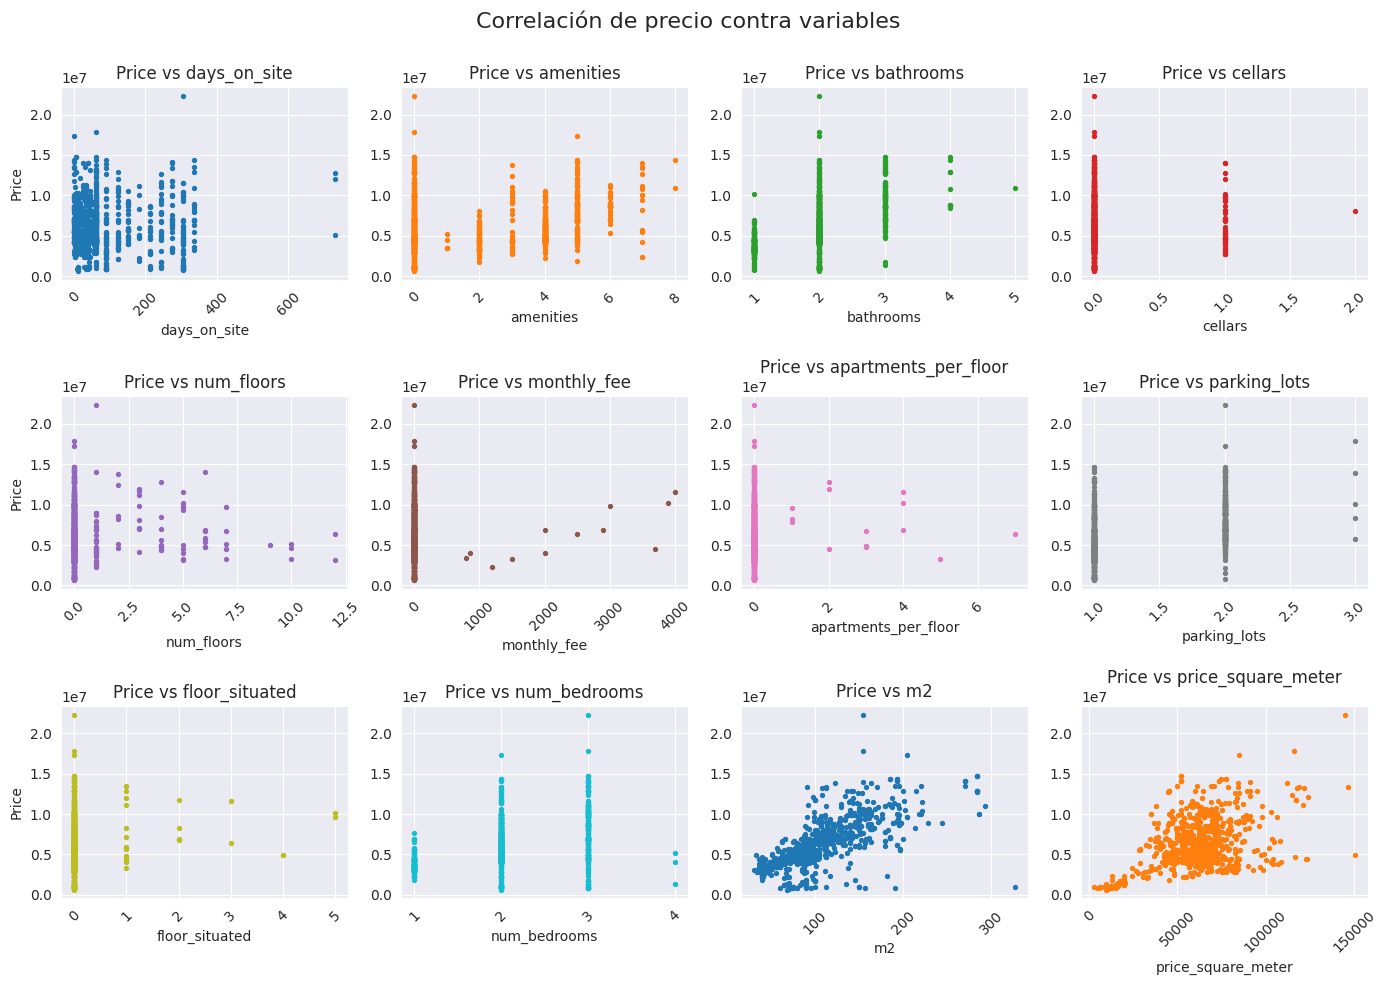

In [459]:
# Take the name of the last 6 columns of the SPY_data which are the model features
variables = data_cdmx[['days_on_site',
       'amenities', 'bathrooms', 'cellars', 'num_floors', 'monthly_fee',
       'apartments_per_floor', 'parking_lots', 'floor_situated',
       'num_bedrooms', 'm2',
       'price_square_meter']]
# variables = data_cdmx.columns[['Number_of_Rooms','House_Inside_Area','Population','Population_Density(km2)','Altitude_min(m)', 'Avg_Temperature','Number_of_Schools','Number_of_Hospital','Region_Area(km2)','Precipitation','Avg_Monthly_Salary','Avg_Age']]

correlation_plot(data_cdmx, variables, 3, 4, figsize=(14,10))

Verificamos los estados en los que se encuentran los departamentos

In [464]:
# A mapbox token is needed for some interactive map plots:
#          https://docs.mapbox.com/help/how-mapbox-works/access-tokens/
mapbox_token = 'pk.eyJ1Ijoiam9zaGJyeCIsImEiOiJjbGoxeDNweG0xODg0M3ByMWRwOHpianhkIn0._BSFDufdKOoOOP5oU4PEqw' # Temporary token share (will be deleted)
px.set_mapbox_access_token(mapbox_token)

In [465]:
cscale = [[0.0, 'rgb(240,0,38)'],
          [0.3, 'rgb(215,48,39)'],
          [0.05, 'rgb(208, 254, 144)'],
          [0.1, 'rgb(0, 255, 179)'],
          [0.3, 'rgb(171,217,233)'],
          [0.7, 'rgb(69,117,230)'],
          [1.0, 'rgb(49,54,255)']]

In [485]:
fig = px.scatter_mapbox(data_cdmx, lat="lat", lon="lon", color="price", size="m2", mapbox_style="mapbox://styles/joshbrx/clj1wusbi030s01p7525act20",
                        zoom=4.1, size_max=20, height=900, width=1000, center=dict(lat=24.37, lon=-103.22))

fig.update_layout(title={"text": 'Apartamentos en venta a lo largo de México', "font": {'size': 24}, "x": 0.5, "y": 0.97})
fig.show()

Segun los datos, se encuentran en 3 estados diferentes:

*   Baja California Norte
*   Nuevo León
*   Ciudad de México



In [480]:
mean_price = np.mean(data_cdmx["price"])
print("Priomedio del precio de los apartamentos en venta: ", mean_price)

Priomedio del precio de los apartamentos en venta:  6144841.7773238


In [484]:
fig = px.scatter_mapbox(data_cdmx[data_cdmx["price"]<=mean_price], lat="lat", lon="lon", color="price", size="m2", mapbox_style="mapbox://styles/joshbrx/clj1wusbi030s01p7525act20",
                        zoom=4.5, size_max=20, height=900, width=1000, center=dict(lat=26.37, lon=-107.22))

fig.update_layout(title={"text": 'Apartamentos con precio menor al promedio ($6,142,855)', "font": {'size': 24}, "x": 0.5, "y": 0.97})
fig.show()

In [483]:
fig = px.scatter_mapbox(data_cdmx[data_cdmx["price"]>=mean_price], lat="lat", lon="lon", color="price", size="m2", mapbox_style="mapbox://styles/joshbrx/clj1wusbi030s01p7525act20",
                        zoom=5.5, size_max=20, height=900, width=1000, center=dict(lat=22.37, lon=-100.22))

fig.update_layout(title={"text": 'Apartamentos con precio mayor al promedio ($6,142,855)', "font": {'size': 24}, "x": 0.5, "y": 0.97})
fig.show()

In [486]:
# Se define una nueva columna para guardar el estado en que se encuentra
def tmp_func4(x):
    tmp_list = np.array([-117.0, -100, -99])
    tmp_var = np.argmin(abs(float(x) - tmp_list))
    if tmp_var == 0: s = "BC Norte"
    if tmp_var == 1: s = "Nuevo León"
    if tmp_var == 2: s = "CDMX"
    return s

data_cdmx["estado"] = data_cdmx["lon"].apply(tmp_func4)
data_cdmx["estado"].unique()

array(['CDMX', 'Nuevo León', 'BC Norte'], dtype=object)

In [487]:
# Se define una otra columna para guardar la distancia a la ciudad más cercana
def tmp_func5(x, columna=data2):
    tmp_list = []
    distance = np.empty(len(x))
    for i in range(len(columna)):
        punto = re.findall(r"(-?\d+\.\d+)", str(columna.iloc[i]))
        tmp_list.append([float(punto[0]), float(punto[1])])
    tmp_list = np.matrix(tmp_list)

    for i in range(len(x)):
        X = np.min(abs(x["lon"].iloc[i] - tmp_list[:,0]))
        Y = np.min(abs(x["lat"].iloc[i] - tmp_list[:,1]))
        distance[i] = np.min(np.sqrt(X**2 + Y**2))

    return distance

data_cdmx["distancia_ciudad"] = tmp_func5(data_cdmx)
data_cdmx[["distancia_ciudad"]].describe()

NameError: ignored